## Imports and Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import logging
import joblib
import torch

import os 
os.chdir('/home/itingzon.unicef/giga')
from utils import calib_utils
from utils import post_utils
from utils import config_utils

%load_ext autoreload
%autoreload 2

## Load Config Files

In [3]:
iso_code = "SEN"
data_config_file = os.path.join(os.getcwd(), "configs/data_configs/data_config_ISO_AF.yaml")
model_config_file = os.path.join(os.getcwd(), "configs/cnn_configs/convnext_large_v01.yaml")
data_config = config_utils.load_config(data_config_file)
model_config = config_utils.load_config(model_config_file)

## Load Validation Results

In [7]:
val_output = calib_utils.get_model_output(iso_code, model_config, phase="val")
test_output = calib_utils.get_model_output(iso_code, model_config, phase="test")
test_output.head(3)

,UID,source,iso,country,region,subregion,name,giga_id_school,clean,validated,class,ghsl_smod,rurban,dataset,geometry,y_true,y_preds,y_probs
0,OSM-SEN-SCHOOL-00000075,OSM,SEN,Senegal,Africa,Sub-Saharan Africa,Ecole d'Elinkine,NaN,0,0.0,school,13,rural,test,POINT (-1645442.8880473897 1541725.5277999148),1,1,0.972682
1,OSM-SEN-SCHOOL-00000161,OSM,SEN,Senegal,Africa,Sub-Saharan Africa,Ecole 1,NaN,0,0.0,school,23,urban,test,POINT (-1319954.9528390914 1954650.5035527328),1,1,0.979420
2,OSM-SEN-SCHOOL-00000185,OSM,SEN,Senegal,Africa,Sub-Saharan Africa,Ecole Elémentaire Tivaouane 13,NaN,0,0.0,school,30,urban,test,POINT (-1648856.406144037 1841900.0392739468),1,1,0.952310


## Load Evaluation

In [10]:
val_results = post_utils.get_evaluation(val_output, beta=2, optim_threshold=None)
test_results = post_utils.get_evaluation(
    test_output, beta=2, optim_threshold=val_results['optim_threshold']
)
for key, value in test_results.items():
    if 'optim' in key: print(f"{key}: {value:.4f}")

optim_threshold: 0.3089
fbeta_score_optim: 94.9407
precision_score_optim: 89.1496
recall_score_optim: 96.5079
f1_score_optim: 92.6829
overall_accuracy_optim: 94.9153
balanced_accuracy_optim: 95.3128


## Plot Results

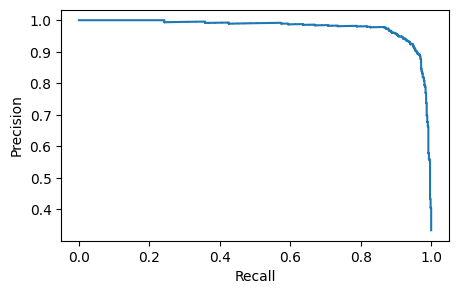

In [11]:
from sklearn.metrics import PrecisionRecallDisplay
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
disp = PrecisionRecallDisplay(
    precision=test_results['precision_scores_'], 
    recall=test_results['recall_scores_']
)
disp.plot(ax=ax);

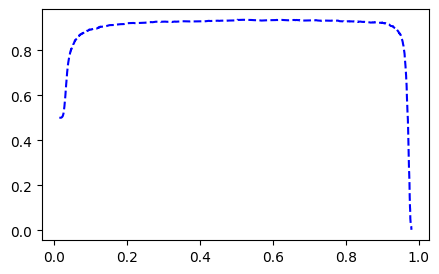

In [15]:
_, test_fscores = eval_utils.get_optimal_threshold(
    test_results['precision_scores_'], 
    test_results['recall_scores_'], 
    test_results['thresholds_'], 
    beta=1
)
fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(test_results['thresholds_'], test_fscores[:-1], "b--");

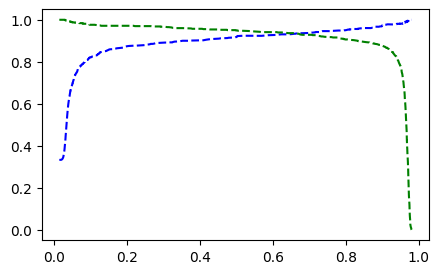

In [13]:
fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(test_results['thresholds_'], test_results['precision_scores_'][:-1], "b--")
ax.plot(test_results['thresholds_'], test_results['recall_scores_'][:-1], "g--");